# Project 4: Team Harvey Wiley



In this project, we will be examining Nigeria's food demand and nutrition, specifically in regards to protein deficiency.

### Preface



Modules you may need to install:



In [47]:
# !pip install CFEDemands --upgrade
# !pip install xarray
# !pip install dvc[gdrive]
# !pip install h5netcdf

We will be using data provided for Nigeria.



In [48]:
COUNTRY = 'Nigeria'

In [49]:
URL = {'Uganda':'https://docs.google.com/spreadsheets/d/1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ/',
       'Tanzania':'https://docs.google.com/spreadsheets/d/1Tknc2F8K6SaA7j0R7J_NE8yJBTsCPPw77_Bfc04MY40/',
       'ICRISAT':'https://docs.google.com/spreadsheets/d/13Ig5hZif-NSHtgkKRp_cEgKXk0lOsdUB2BAD6O_FnRo',
       'Nigeria':{'Expenditures':'https://docs.google.com/spreadsheets/d/1qzz6XGhPWLZLmwjrUY4W9k9U2PYukWblQKXWu0l37C4/',
                  'FCT':'https://docs.google.com/spreadsheets/d/1whE_EW5x-jxrsKvYWfefdBppzp_TZhPP61bdEN-FEJ4/',
                  'RDI':'https://docs.google.com/spreadsheets/d/1whE_EW5x-jxrsKvYWfefdBppzp_TZhPP61bdEN-FEJ4/',
                  'HH Characteristics':'https://docs.google.com/spreadsheets/d/1whE_EW5x-jxrsKvYWfefdBppzp_TZhPP61bdEN-FEJ4/',
                  'Prices':'https://docs.google.com/spreadsheets/d/1whE_EW5x-jxrsKvYWfefdBppzp_TZhPP61bdEN-FEJ4/'}
                  }
DAYS_PER_PERIOD = {'Uganda':7,'Tanzania':7,'ICRISAT':365.25,'Nigeria':7} # Number of days of expenditure recall

To read the various sheets, we&rsquo;ll need some credentials.  Point to an
unencrypted json file that has the appropriate permissions:



In [50]:
my_creds = '../students.json'

### Estimation



First, we pull in data on expenditures, household characteristics,
   and price:



In [51]:
import cfe
import numpy as np
from eep153_tools import read_sheets

x = read_sheets(URL[COUNTRY],json_creds=my_creds,sheet='Expenditures')

if len(x.columns==5): # stored as a series
    x = x.set_index(['j','t','m','i']).squeeze()
    x = x.unstack('i')
else:    
    x = x.set_index(['j','t','m'])
    x.columns.name = 'i'
    
x = x.replace(0,np.nan)
y = np.log(x)

z = read_sheets(URL[COUNTRY],json_creds=my_creds,sheet='HH Characteristics').set_index(['j','t','m'])
z.columns.name = 'k'

p = read_sheets(URL[COUNTRY],json_creds=my_creds,sheet='Prices').set_index(['t','m'])
p.columns.name = 'i'

Setting our use_periods to only look at the four periods below to prevent the kernel from dying.



In [52]:
# use_periods = "t in %s" % str(p.index.levels[0].tolist())

# If you want to use just a subset of periods, redefine
# use_periods here; e.g.,
#
use_periods ="t in ['2015Q3','2016Q1','2018Q3','2019Q1']"

Next, we construct an object we can use in the estimation.



In [53]:
r = cfe.Result(y=y.query(use_periods),
               z=z.query(use_periods),
               prices=p.query(use_periods))

Next, we estimate CFE demands *given* the prices and budgets of households in the data.



In [54]:
r.get_alpha()
xhat = r.get_predicted_expenditures()

/opt/conda/lib/python3.8/site-packages/xarray/core/nputils.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


Estimation is kind of expensive, so you might want to save these
results to use in your later code.



In [55]:
r.to_dataset("my %s.ds" % COUNTRY)

/opt/conda/lib/python3.8/site-packages/h5netcdf/core.py:769: FutureWarning: String decoding changed with h5py >= 3.0. See https://docs.h5py.org/en/latest/strings.html for more details. Currently backwards compatibility with h5py < 3.0 is kept by decoding vlen strings per default. This will change in future versions for consistency with h5py >= 3.0. To silence this warning set kwarg ``decode_vlen_strings=False``. Setting ``decode_vlen_strings=True`` forces vlen string decoding.
  warnings.warn(msg, FutureWarning, stacklevel=0)


<xarray.Dataset>
Dimensions:           (i: 107, j: 8211, k: 15, kp: 15, m: 6, t: 4)
Coordinates:
  * j                 (j) int64 10001 10002 10003 10004 ... 379152 379154 379155
  * i                 (i) object 'Apples' 'Avocado pear' ... 'Yam--roots'
  * k                 (k) object 'M 00-03' 'M 04-08' ... 'F 51+' 'log HHSize'
  * t                 (t) object '2015Q3' '2016Q1' '2018Q3' '2019Q1'
  * m                 (m) object 'North central' 'North east' ... 'South west'
  * kp                (kp) <U10 'F 00-03' 'F 04-08' ... 'M 51+' 'log HHSize'
Data variables:
    alpha             (i) float64 nan nan nan 4.786 ... 5.413 nan nan 5.904
    beta              (i) float64 nan nan nan 0.2943 ... 0.3192 nan nan 0.2411
    delta             (k, i) float64 nan nan nan 0.03544 ... nan nan 0.2673
    prices            (i, t, m) float64 nan 6e+03 nan nan ... 350.0 216.7 160.0
    characteristics   (k, j, t, m) float64 nan nan nan 1.0 ... nan nan nan nan
    loglambdas        (j, t, m) float64 nan nan nan 0.05436 ... nan nan nan nan
    a                 (i, t, m) float64 nan nan nan nan ... 6.042 6.393 6.218
    yhat              (j, t, m, i) float64 nan nan nan nan ... nan nan nan nan
    ce                (j, t, m, i) float64 nan nan nan nan ... nan nan nan nan
    cehat             (j, t, m, i) float64 nan nan nan nan ... nan nan nan nan
    e                 (i, j, m, t) float64 nan nan nan nan ... nan nan nan nan
    delta_covariance  (i, k, kp) float64 nan nan nan ... -0.000465 0.00163
    beta_covariance   object None
    se_delta          (i, k) float64 nan nan nan nan ... 0.0239 0.0258 0.04038
    se_beta           object None
    se_alpha          (i) float64 0.0 0.0 0.0 0.0282 ... 0.01965 0.0 0.0 0.02053
    se_a              (i, t, m) float64 nan nan nan ... 0.04643 0.0568 0.04597
    y                 (i, j, m, t) float64 nan nan nan nan ... nan nan nan nan
    logp              (i, t, m) float64 nan 8.7 nan nan ... 5.858 5.378 5.075
    z                 (k, j, t, m) float64 nan nan nan 1.0 ... nan nan nan nan

### Plotting Food Demands



Now we&rsquo;re interested in predicting what quantities of different
   kinds of food *would* have been, if something (e.g., a price,
   budget, household characteristics) was different.



#### Ceteris paribus



We begin by setting up some benchmarks for prices and budgets, so
   the things we don&rsquo;t want to change we can hold fixed.



In [56]:
### First year, first market, and some good.  Change if you wish! ###
my_t = r.coords['t'].data.flatten()[0]
my_m = r.coords['m'].data.flatten()[0]
my_i = r.get_beta(as_df=True).sort_values(ascending=False).index[0]
#####################################################################

p = r.prices.sel(t=my_t,m=my_m,drop=True)
phat = p.to_dataframe('i').dropna().squeeze()

ref_price = r.prices.sel(i=my_i,t=my_t,m=my_m)
P = np.linspace(ref_price/10,ref_price*5,50)

def my_prices(p0,p=phat,i=my_i):
    """
    Set price of good i to p0, holding remaining prices fixed at values in p.
    """
    p = p.copy()
    p.loc[i] = p0
    return p.squeeze()

So, we have a budget for median household at that time and place



In [57]:
xbar = r.get_predicted_expenditures().sum('i')
median_x = xbar.where(xbar>0).sel(t=my_t,m=my_m).median('j') # Budget (median household)

/opt/conda/lib/python3.8/site-packages/xarray/core/nputils.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


In [82]:

c=r.demands(median_x,p).sort_values(ascending=False)
c.to_frame()


,quantities
i,
Sachet water,0.975511
Yam--roots,0.918443
Sweet potatoes,0.728594
Salt,0.688369
Chicken,0.677406
Rice--imported,0.656423
White beans,0.653467
Goat,0.588998
Gari,0.586761


### Plotting Nutrient Demands



In [85]:
fct.loc['Beef']

n
Energy          3210.0
Protein          175.0
Fiber              0.0
Folate           100.0
Calcium          300.0
Carbohydrate       0.0
Iron              11.0
Magnesium        150.0
Niacin            42.0
Phosphorus      1380.0
Potassium       2320.0
Riboflavin         1.1
Thiamin            1.0
Vitamin A        280.0
Vitamin B-12      16.0
Vitamin B-6        3.7
Vitamin C          0.0
Vitamin E          7.6
Zinc              30.9
Fat, total       279.0
Retinol          280.0
Name: Beef, dtype: float64

The nutrient value of food consumed by the household is just the
   product of its diet and a food conversion table.  So let&rsquo;s write a
   function that describes that product:



In [58]:
# Get FCT:
fct = read_sheets(URL[COUNTRY],
                  json_creds='../students.json',
                  sheet='FCT').set_index('i')
fct.columns.name='n'

def nutrient_demand(x,p):
    c = r.demands(x,p)
    fct0,c0 = fct.align(c,axis=0,join='inner')
    N = fct0.T@c0

    N = N.loc[~N.index.duplicated()]
    
    return N

In [59]:
fct = fct.fillna(0)

With this `nutrient_demand` function in hand, we can see how nutrient
 outcomes vary with budget, given prices:



Text(0, 0.5, 'log nutrient')

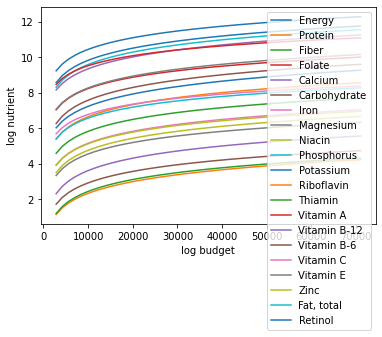

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### If you're getting lots of not useful warnings you want to ignore
# import warnings
# warnings.filterwarnings('ignore',category=UserWarning)
####################################################################

X = np.linspace(median_x/5,median_x*5,50)

UseNutrients = ['Protein','Calories','Iron','Calcium']
UseNutrients = fct.columns.tolist()

plt.plot(X,pd.concat({x:np.log(nutrient_demand(x,p))[UseNutrients] for x in X},axis=1).T)
plt.legend(UseNutrients)
plt.xlabel('log budget')
plt.ylabel('log nutrient')

### Nutritional requirements



Individuals have nutritional requirements established by nutrition
 scientists.  Here we grab one such set of requirements:



In [61]:
rdi = read_sheets(URL[COUNTRY],
                  json_creds='../students.json',
                  sheet='RDI').set_index('n').replace(np.nan,0)
rdi.columns.name = 'k'


rdi = rdi.replace('',0)
rdi

k,F 00-03,M 00-03,F 04-08,M 04-08,F 09-13,M 09-13,F 14-18,M 14-18,F 19-30,M 19-30,F 31-50,M 31-50,F 51+,M 51+
n,,,,,,,,,,,,,,
Energy,1000.0,1000.0,1200.0,1400.0,1600.0,1800.0,1800.0,2200.0,2000.0,2400.0,1800.0,2200.0,1600.0,2000.0
Protein,13.0,13.0,19.0,19.0,34.0,34.0,46.0,52.0,46.0,56.0,46.0,56.0,46.0,56.0
Fiber,14.0,14.0,16.8,19.6,22.4,25.2,25.2,30.8,28.0,33.6,25.2,30.8,22.4,28.0
Folate,150.0,150.0,200.0,200.0,300.0,300.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0
Calcium,700.0,700.0,1000.0,1000.0,1300.0,1300.0,1300.0,1300.0,1000.0,1000.0,1000.0,1000.0,1200.0,1000.0
Carbohydrate,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0
Iron,7.0,7.0,10.0,10.0,8.0,8.0,15.0,11.0,18.0,8.0,18.0,8.0,8.0,8.0
Magnesium,80.0,80.0,130.0,130.0,240.0,240.0,360.0,410.0,310.0,400.0,320.0,420.0,320.0,420.0
Niacin,6.0,6.0,8.0,8.0,12.0,12.0,14.0,16.0,14.0,16.0,14.0,16.0,14.0,16.0


#### Nutritional Needs of Households



Our data on demand and nutrients is at the *household* level; we
    can&rsquo;t directly compare household level nutrition with individual
    level requirements.  What we **can** do is add up minimum individual
    requirements, and see whether household total exceed these.  This
    isn&rsquo;t a guarantee that all individuals have adequate nutrition
    (since the way food is allocated in the household might be quite
    unequal, or unrelated to individual requirements), but it is
    *necessary* if all individuals are to have adequate nutrition.

For the average household, the number of different kinds of people
can be computed by averaging over households:



In [62]:
# Find average household characteristics for reference period & place
zbar = r.z.sel(t=my_t,m=my_m,drop=True).mean('j').to_dataframe()

Now, the inner/dot/matrix product between `zbar` and the `rda`
 DataFrame of requirements will give us minimum requirements for the
 average household:



In [63]:
# This matrix product gives minimum nutrient requirements for average
# household in reference year & place
my_rdi,my_zbar = rdi.align(zbar.T,axis=1,join='inner')
hh_rdi = my_rdi@my_zbar.T

# But this is per *day*, while our data is per period:
hh_rdi = hh_rdi*DAYS_PER_PERIOD[COUNTRY]
hh_rdi

,z
n,
Energy,72317.424242
Protein,1632.467172
Fiber,1012.443939
Folate,13600.505051
Calcium,43690.782828
Carbohydrate,5271.565657
Iron,440.849747
Magnesium,11737.727273
Niacin,518.229798


#### Nutritional Adequacy of Food Demands



Since we can trace out demands for nutrients as a function of $(x,p)$,
 and we&rsquo;ve computed minimum nutritional requirements for the average
 household, we can *normalize* nutritional intake to check the adequacy
 of diet.



In [64]:
def nutrient_adequacy_ratio(x,p):
    return (nutrient_demand(x,p)/hh_rdi.T).squeeze()

In terms of normalized nutrients, any household with more than one
 unit of any given nutrient (or zero in logs) will be consuming a
 minimally adequate level of the nutrient; below this level there&rsquo;s
 clearly nutritional inadequacy.  For this reason the ratio of
 actual nutrients to required nutrients is termed the &ldquo;nutrient
 adequacy ratio,&rdquo; or NAR.



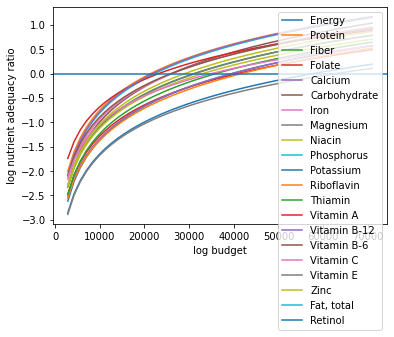

In [65]:
plt.plot(X,pd.concat({x:np.log(nutrient_adequacy_ratio(x,p))[UseNutrients] for x in X},axis=1).T)
plt.legend(UseNutrients)
plt.xlabel('log budget')
plt.ylabel('log nutrient adequacy ratio')
plt.axhline(0)

As before, we can also vary relative prices.  Here we trace out
 nutritional adequacy varying the price of a single good:



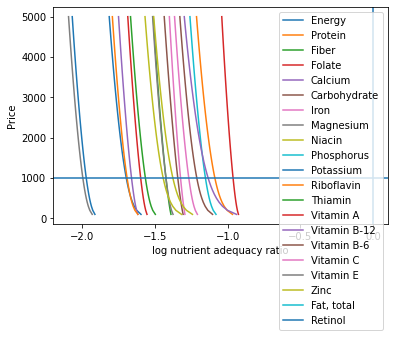

In [89]:
poorer_x = median_x/2

plt.plot(pd.concat({p0:np.log(nutrient_adequacy_ratio(poorer_x,my_prices(p0,i='Beef')))[UseNutrients] for p0 in P},axis=1).T,P)
plt.legend(UseNutrients)
plt.ylabel('Price')
plt.xlabel('log nutrient adequacy ratio')
plt.axvline(0)
plt.axhline(p.sel(i='Beef').values)

According to both the data here, as well as external research, we've found that protein deficiencies are often common in Nigerian household and are extremely prevalent throughout the country. Because of this, we are going to focus our policy goals on just increasing protein intake in households. Let's first examine the nutrient adequacy ratio of only protein.

In [67]:
UseNutrients = ['Protein']

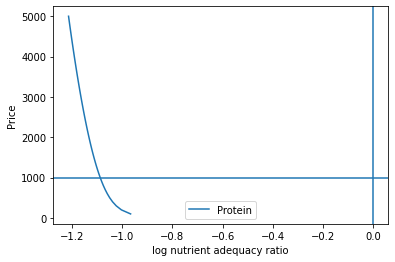

In [86]:
poorer_x = median_x/2

plt.plot(pd.concat({p0:np.log(nutrient_adequacy_ratio(poorer_x,my_prices(p0,i='Beef')))[UseNutrients] for p0 in P},axis=1).T,P)
plt.legend(UseNutrients)
plt.ylabel('Price')
plt.xlabel('log nutrient adequacy ratio')
plt.axvline(0)
plt.axhline(p.sel(i='Beef').values)

## Policy Experiments

Let's first see the highest protein-dense foods consumed in households.

In [69]:
protein = fct.loc[:, 'Protein'].to_frame().sort_values(by='Protein', ascending = False).head(15)
protein

,Protein
i,
Wild game meat,667.0
Fish--dried,604.0
Soya beans,313.0
Milk powder,258.0
Canned fish/seafood,248.0
Brown beans,238.0
White beans,213.0
Groundnuts,195.0
Mutton,193.0


In [70]:
# A quantile of 0.5 is the median.  Play with quantile value, or just assign.
xbar = r.get_predicted_expenditures().sel(t=my_t,m=my_m).sum('i')

# Drop households with /no/ predicted expenditures
xbar = xbar.where(xbar>0)

x0 = xbar.quantile(0.5,'j') # Budget (median household)
#x0 = 50

# Range of budgets to explore
X = np.linspace(x0/10,x0*5,50)

/opt/conda/lib/python3.8/site-packages/xarray/core/nputils.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


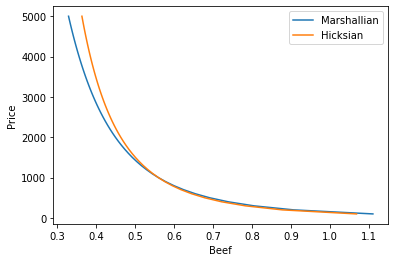

In [71]:
import matplotlib.pyplot as plt

#my_i = 'Milk'
my_i = 'Beef'
ref_price = r.prices.sel(i=my_i,t=my_t,m=my_m)
P = np.linspace(ref_price/10,ref_price*5,50)

U0 = r.indirect_utility(x0,p)

### If you're getting lots of not useful warnings you want to ignore
# import warnings
# warnings.filterwarnings('ignore',category=UserWarning)
####################################################################

plt.plot([r.demands(x0,my_prices(p0,i=my_i))[my_i] for p0 in P],P)
plt.plot([r.demands(U0,my_prices(p0,i=my_i),type="Hicksian")[my_i] for p0 in P],P)
plt.ylabel('Price')
plt.xlabel(my_i)
#plt.axhline(p.sel(i=my_i).values)
plt.legend(("Marshallian","Hicksian"))

In [72]:
def compensating_variation(U0,p0,p1):
    x0 = r.expenditure(U0,p0)
    x1 = r.expenditure(U0,p1)

    return x1-x0

def revenue(U0,p0,p1,type='Marshallian'):
    """(Un)Compensated revenue from taxes changing vector of prices from p0 to p1.

    Note that this is only for *demand* side (i.e., if supply perfectly elastic).
    """
    
    dp = p1 - p0 # Change in prices

    c = r.demands(U0,p1,type=type)

    dp,c = dp.align(c,join='inner')

    return dp.T@c


def deadweight_loss(U0,p0,p1):
    """
    Deadweight loss of tax/subsidy scheme creating wedge in prices from p0 to p1.

    Note that this is only for *demand* side (i.e., if supply perfectly elastic).
    """
    cv = compensating_variation(U0,p0,p1)

    return cv - revenue(U0,p0,p1,type='Hicksian') 
    
    
def compensated_nutrient_demand(U,p,z=None):
    c = r.demands(U,p,z=z,type='Hicksian')
    fct0,c0 = fct.align(c,axis=0,join='inner')
    N = fct0.T@c0

    return N

def compensated_nutrient_adequacy_ratio(U,p):
    return (compensated_nutrient_demand(U,p)/hh_rdi.T).squeeze()

Let's first examine how the nutrient adequacy ratio changes with adjustments to price in beef.

Text(0.5, 0, 'Price of Beef')

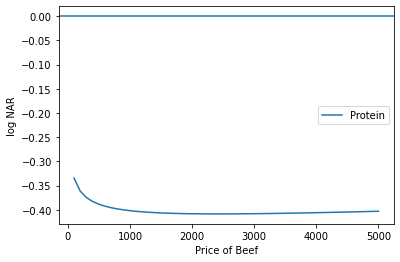

In [73]:
my_i = 'Beef'

fig,ax2 = plt.subplots()
ax2.set_ylabel('log NAR')
ax2.plot(P,[np.log(compensated_nutrient_adequacy_ratio(U0,my_prices(p0,i=my_i))[UseNutrients]) for p0 in P])
ax2.legend(UseNutrients)
ax2.axhline(0)
ax2.set_xlabel("Price of %s" % my_i)

In [74]:
phat

i
Baby milk powder    2000.000000
Bananas              450.000000
Beef                1000.000000
Beer                2500.000000
Biscuits             458.333333
                       ...     
Watermelon           325.000000
Wheat flour          175.000000
White beans          220.000000
Wild game meat       676.923080
Yam--roots           135.000000
Name: i, Length: 68, dtype: float64

However, seeing that beef is one of the more expensive ingredients consumed in households, we will still explore how different policy options may increae beef consumption for various households. Let's also look at one more food high in protein and commonly consumed in Nigeria: dried fish.

Text(0.5, 0, 'Price of Fish--dried')

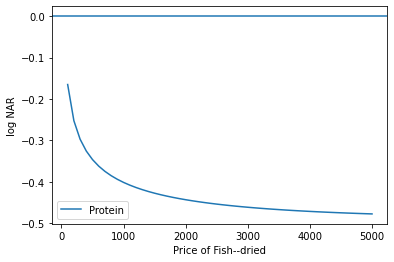

In [75]:
my_i2 = 'Fish--dried'

fig,ax2 = plt.subplots()
ax2.set_ylabel('log NAR')
ax2.plot(P,[np.log(compensated_nutrient_adequacy_ratio(U0,my_prices(p0,i=my_i2))[UseNutrients]) for p0 in P])
ax2.legend(UseNutrients)
ax2.axhline(0)
ax2.set_xlabel("Price of %s" % my_i2)

Dried fish does seem to have a more substantial impact on the nutrient adequacy ratio, likely due to the fact that it is a lot cheaper. As of now, we have yet to calculate the effects of price changes on revenue and compensating variation as well as deadweightloss, but are working on it for our final project. 

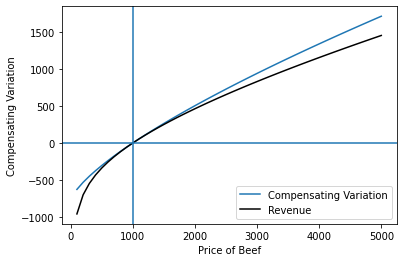

In [76]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()

ax1.plot(P,[compensating_variation(U0,phat,my_prices(p0,i=my_i)) for p0 in P])
ax1.set_xlabel("Price of %s" % my_i)
ax1.set_ylabel("Compensating Variation")

ax1.plot(P,[revenue(U0,phat,my_prices(p0,i=my_i),type='Hicksian') for p0 in P],'k')
ax1.legend(('Compensating Variation','Revenue'))
ax1.axhline(0)
ax1.axvline(phat.loc[my_i])

In [77]:
phat

i
Baby milk powder    2000.000000
Bananas              450.000000
Beef                1000.000000
Beer                2500.000000
Biscuits             458.333333
                       ...     
Watermelon           325.000000
Wheat flour          175.000000
White beans          220.000000
Wild game meat       676.923080
Yam--roots           135.000000
Name: i, Length: 68, dtype: float64

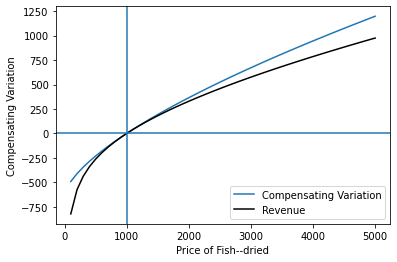

In [78]:
fig, ax1 = plt.subplots()
ax1.plot(P,[compensating_variation(U0,phat,my_prices(p0,i=my_i2)) for p0 in P])
ax1.set_xlabel("Price of %s" % my_i2)
ax1.set_ylabel("Compensating Variation")

ax1.plot(P,[revenue(U0,phat,my_prices(p0,i=my_i2),type='Hicksian') for p0 in P],'k')
ax1.legend(('Compensating Variation','Revenue'))
ax1.axhline(0)
ax1.axvline(phat.loc[my_i2])

Text(0, 0.5, 'Deadweight Loss')

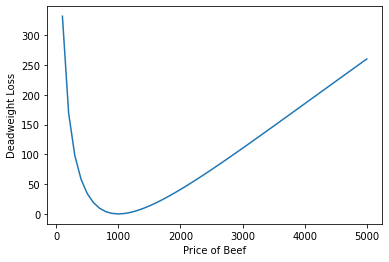

In [79]:
fig, ax1 = plt.subplots()

ax1.plot(P,[deadweight_loss(U0,phat,my_prices(p0,i=my_i)) for p0 in P])
ax1.set_xlabel("Price of %s" % my_i)
ax1.set_ylabel("Deadweight Loss")